# Drowsiness Detection 
This introductory section outlines the objective of the notebook, which is to develop a predictive model capable of identifying signs of drowsiness by analyzing the state of a person's eyes. Applications of such a model are crucial in areas like real-time monitoring systems to enhance driver safety.

# Importing Relevant Python Packages
In this section, essential Python libraries are imported, each serving a specific function.

In [83]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import os
import cv2
import dlib
import pandas as pd
import dlib
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt
from skimage.filters import sobel
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing Relevant Data
Data import involves loading images of closed and open eyes from designated directories. Functions are defined to automate the listing of image files and the creation of a dataframe for these images, facilitating easier data handling.

In [84]:
closed_eye_data = 'data/Closed_eye'
open_eye_data = 'data/Opened_eye'
data_folder = 'data/'

In [85]:
def list_image_files(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))]


def create_image_dataframe(directory):
    image_files = list_image_files(directory)
    df = pd.DataFrame(image_files, columns=['Image Path'])
    return df

In [86]:
# Taking a look at our dataset of closed_eye_data
directory = closed_eye_data
image_df = create_image_dataframe(directory)
image_df.head()

,Image Path
0,data/Closed_eye/8.jpg
1,data/Closed_eye/9.jpg
2,data/Closed_eye/14.jpg
3,data/Closed_eye/28.jpg
4,data/Closed_eye/29.jpg


In [87]:
# Taking a look at our dataset of Opened_eye_data
directory = open_eye_data
image_df = create_image_dataframe(directory)
image_df.head()

,Image Path
0,data/Opened_eye/8.jpg
1,data/Opened_eye/9.jpg
2,data/Opened_eye/14.jpg
3,data/Opened_eye/28.jpg
4,data/Opened_eye/29.jpg


# Face Detection and Facial Landmark Identification with Dlib

The `dlib` library is a powerful, widely-used C++ library that is utilized in Python for various machine learning, computer vision, and image processing tasks. One of the primary applications of `dlib` is in the field of facial recognition and analysis. Here's how `dlib` can be used to detect faces and identify facial landmarks within images:

### Face Detection
To detect a face in an image, `dlib` utilizes a pre-trained deep learning model which identifies faces by analyzing the patterns and features that represent a human face. This model is highly efficient and accurate, making it suitable for real-time face detection applications.

### Facial Landmark Detection
Once a face is detected, `dlib` can further analyze the face to locate 68 specific points or landmarks on the face. These landmarks identify key regions of the face such as the eyes, nose, mouth, and jawline. Detecting these points is crucial for more advanced tasks such as facial feature tracking, emotion recognition, and various augmented reality applications.


In [88]:
# Path to the trained model for facial landmarks
PREDICTOR_PATH = "model/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

## Snippet of Landmark Detection

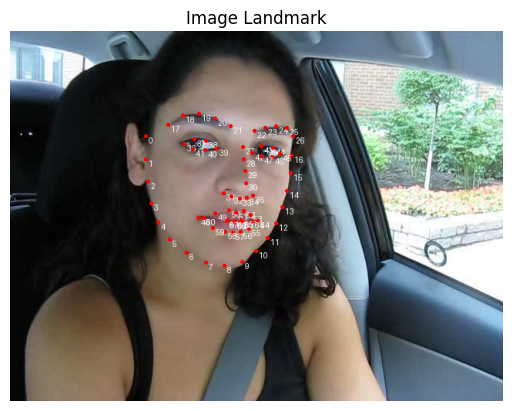

In [89]:
image_path = 'data/Opened_eye/17.jpg' 
image = Image.open(image_path)
image = image.convert('RGB') 

# Convert image to array for dlib and detect faces
image_array = np.array(image)
detected_faces = detector(image_array, 1)

# Create a draw object to annotate the image (on the PIL Image)
draw = ImageDraw.Draw(image)

# Process each face detected
for face in detected_faces:
    # Get the landmarks/parts for the face
    landmarks = predictor(image_array, face)
    for i, part in enumerate(landmarks.parts()):
        # Draw a circle per landmark and annotate it
        x, y = part.x, part.y
        draw.ellipse((x-2, y-2, x+2, y+2), fill=(255, 0, 0), outline=(255, 0, 0))
        draw.text((x+4, y), str(i), fill=(255, 255, 255))  # Number the landmark

# Use matplotlib to display the image with landmarks
fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')  # Hide the axes
plt.title('Image Landmark')
plt.show()

# Eye Aspect Ratio (EAR)

The **Eye Aspect Ratio (EAR)** is a simple, yet effective geometric measure used to determine the state of a person's eyelids, specifically whether they are open or closed. This measurement is particularly useful in fields like driver drowsiness detection, where it's essential to monitor whether a driver's eyes are closed.

- **Lower EAR values** indicate that the eye is more closed.
- **Higher EAR values** suggest the eye is open.

The threshold for determining whether the eyes are closed or open needs to be empirically set based on the specific application and the population being studied.


## Snippet of calculating Eye Aspect Ratio (EAR) 

In [90]:
# Eye Aspect Ratio calculation
def eye_aspect_ratio(eye):
    A = np.linalg.norm(np.array(eye[1]) - np.array(eye[5]))
    B = np.linalg.norm(np.array(eye[2]) - np.array(eye[4]))
    C = np.linalg.norm(np.array(eye[0]) - np.array(eye[3]))
    return (A + B) / (2.0 * C)

# Function to draw polygons around the eyes
def draw_polygons(frame, landmarks):
    left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

    left_eye_polygon = np.array(left_eye_points, np.int32)
    right_eye_polygon = np.array(right_eye_points, np.int32)

    cv2.polylines(frame, [left_eye_polygon], True, (0, 255, 0), 1)
    cv2.polylines(frame, [right_eye_polygon], True, (0, 255, 0), 1)

Left Eye: Open (EAR: 0.297), Right Eye: Open (EAR: 0.348)


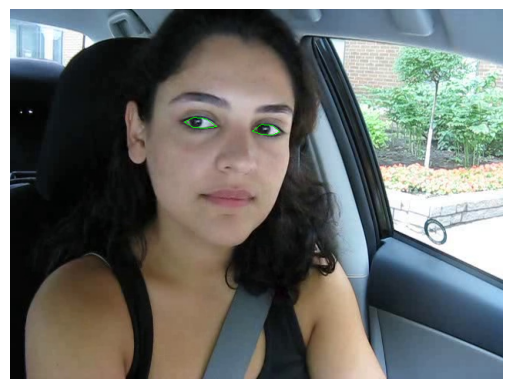

In [91]:
# Load an image
image_path = 'data/Opened_eye/17.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
faces = detector(image_rgb, 1)

# Process each face detected
for face in faces:
    landmarks = predictor(image_rgb, face)
    draw_polygons(image_rgb, landmarks)

    # Calculate EAR for both eyes
    left_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
    ear_left = eye_aspect_ratio(left_eye)
    ear_right = eye_aspect_ratio(right_eye)

    # Determine if each eye is open or closed
    left_eye_status = 'Closed' if ear_left < 0.2 else 'Open'
    right_eye_status = 'Closed' if ear_right < 0.2 else 'Open'

    # Print the results
    print(f'Left Eye: {left_eye_status} (EAR: {ear_left:.3f}), Right Eye: {right_eye_status} (EAR: {ear_right:.3f})')

# Display the image with drawn polygons around the eyes
fig, ax = plt.subplots()
ax.imshow(image_rgb)
ax.axis('off')  # Hide the axes
plt.show()


# Building Our Dataset

In this project, we aim to combine our understanding of facial landmark detection and the Eye Aspect Ratio (EAR) calculation to create a comprehensive dataset. This dataset will catalog images as either having 'opened eyes' or 'closed eyes'.

## Calculating having 'opened eyes' or 'closed eyes' 

In [92]:
# Constants
EAR_THRESHOLD = 0.2

# Function to process each image
def process_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)
        left_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
        right_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
        ear_left = eye_aspect_ratio(left_eye)
        ear_right = eye_aspect_ratio(right_eye)

        # Check if either eye's EAR is above the threshold
        overall_eye_status = 'Open' if ear_left >= EAR_THRESHOLD or ear_right >= EAR_THRESHOLD else 'Closed'

        return {
            'image_path': image_path,
            'ear_left': ear_left,
            'ear_right': ear_right,
            'overall_eye_status': overall_eye_status
        }

    return None  

def build_dataset(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(directory, filename)
            result = process_image(image_path)
            if result:
                data.append(result)
    
    return pd.DataFrame(data)


In [93]:
# using the Default EAR_THRESHOLD = 0.2 and no data Processing done! 
directory = closed_eye_data 
df = build_dataset(directory)
df

,image_path,ear_left,ear_right,overall_eye_status
0,data/Closed_eye/8.jpg,0.162838,0.148244,Closed
1,data/Closed_eye/9.jpg,0.194012,0.184592,Closed
2,data/Closed_eye/14.jpg,0.258473,0.253837,Open
3,data/Closed_eye/28.jpg,0.177231,0.179929,Closed
4,data/Closed_eye/29.jpg,0.230376,0.211284,Open
5,data/Closed_eye/15.jpg,0.287586,0.304759,Open
6,data/Closed_eye/16.jpg,0.225469,0.247454,Open
7,data/Closed_eye/12.jpg,0.373837,0.373012,Open
8,data/Closed_eye/11.jpg,0.123530,0.121730,Closed
9,data/Closed_eye/10.jpg,0.164149,0.167139,Closed


# Data Processing 

As you may have noticed, some images labeled as "open" in our dataset were actually from the closed-eye dataset, highlight a critical aspect of **the importance of fine-tuning and meticulous data processing**. 

Steps include converting images to grayscale, applying adaptive histogram equalization, Gaussian blur for noise reduction, and optional edge enhancement. Preprocessed images are saved for subsequent modeling.

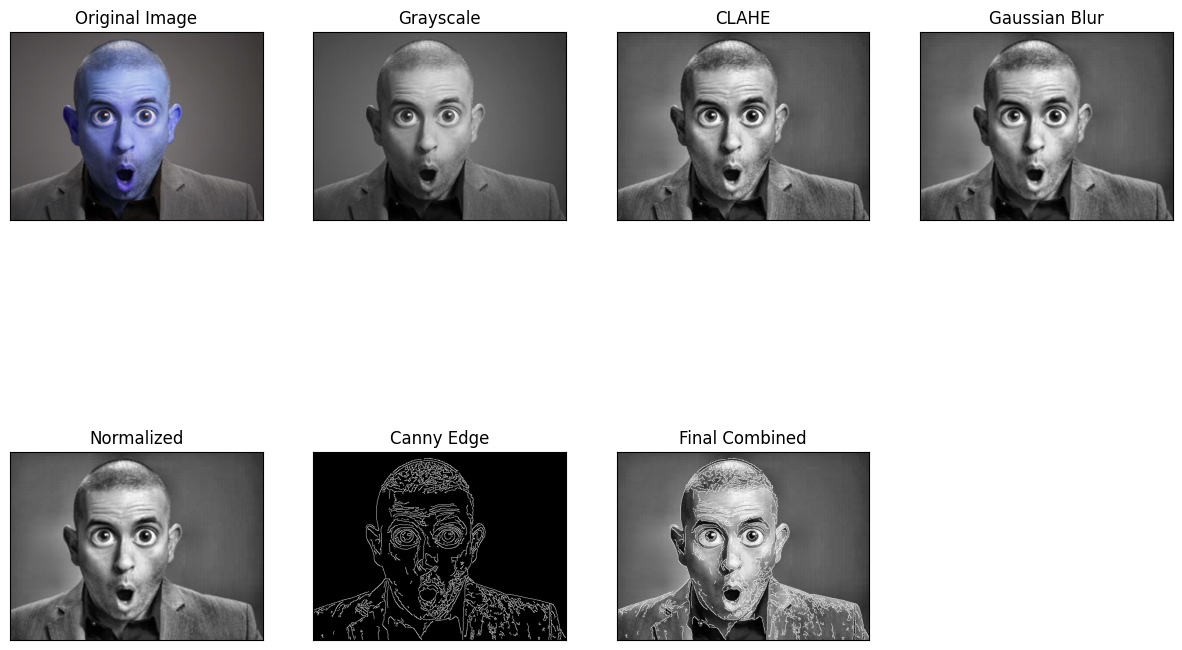

In [111]:

def preprocessed_eye_advanced(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Check if image is loaded properly
    if image is None:
        print("Error: Image could not be read.")
        return None

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive histogram equalization using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eq_image = clahe.apply(gray_image)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(eq_image, (3, 3), 0)

    # Normalize the image to scale the pixel values between 0 and 255 for proper visibility
    normalized_image = cv2.normalize(blurred_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Apply Canny edge detection
    edge_enhanced_image = cv2.Canny(normalized_image, 50, 100)  

    # Optionally, combine the normalized image with the edge detection for better visibility
    final_image = cv2.add(normalized_image, edge_enhanced_image)

    # Display images
    titles = ['Original Image', 'Grayscale', 'CLAHE', 'Gaussian Blur', 'Normalized', 'Canny Edge', 'Final Combined']
    images = [image, gray_image, eq_image, blurred_image, normalized_image, edge_enhanced_image, final_image]

    plt.figure(figsize=(15, 10))
    for i in range(7):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.show()

    return final_image

processed_image = preprocessed_eye_advanced('generalization/gen_test_1.png')


In [94]:
def preprocessed_eye_advanced(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Check if image is loaded properly
    if image is None:
        print("Error: Image could not be read.")
        return None

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive histogram equalization using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eq_image = clahe.apply(gray_image)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(eq_image, (3, 3), 0)

    # Normalize the image to scale the pixel values between 0 and 255 for proper visibility
    normalized_image = cv2.normalize(blurred_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Apply Canny edge detection
    edge_enhanced_image = cv2.Canny(normalized_image, 50, 100)  

    # Optionally, combine the normalized image with the edge detection for better visibility
    final_image = cv2.add(normalized_image, edge_enhanced_image)

    return final_image


def process_images_in_directory(input_directory, output_directory):
    # Create the output directory if it does not exist
    os.makedirs(output_directory, exist_ok=True)

    # Loop through all images in the input directory
    for filename in os.listdir(input_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_directory, filename)
            processed_image = preprocessed_eye_advanced(image_path)
            if processed_image is not None:
                save_path = os.path.join(output_directory, filename)
                cv2.imwrite(save_path, processed_image)  # Save the processed image
                print(f"Processed and saved: {save_path}")


In [95]:
output_directory_closed_eye = 'data/preprocessed_closed_eye'
output_directory_open_eye = 'data/preprocessed_open_eye'

In [96]:
# Processing our closed_eye_data
process_images_in_directory(closed_eye_data, output_directory_closed_eye) 

Processed and saved: data/preprocessed_closed_eye/8.jpg
Processed and saved: data/preprocessed_closed_eye/9.jpg
Processed and saved: data/preprocessed_closed_eye/14.jpg
Processed and saved: data/preprocessed_closed_eye/28.jpg
Processed and saved: data/preprocessed_closed_eye/29.jpg
Processed and saved: data/preprocessed_closed_eye/15.jpg
Processed and saved: data/preprocessed_closed_eye/17.jpg
Processed and saved: data/preprocessed_closed_eye/16.jpg
Processed and saved: data/preprocessed_closed_eye/12.jpg
Processed and saved: data/preprocessed_closed_eye/13.jpg
Processed and saved: data/preprocessed_closed_eye/11.jpg
Processed and saved: data/preprocessed_closed_eye/10.jpg
Processed and saved: data/preprocessed_closed_eye/21.jpg
Processed and saved: data/preprocessed_closed_eye/20.jpg
Processed and saved: data/preprocessed_closed_eye/22.jpg
Processed and saved: data/preprocessed_closed_eye/23.jpg
Processed and saved: data/preprocessed_closed_eye/27.jpg
Processed and saved: data/preproc

In [97]:
# Processing our closed_eye_data
process_images_in_directory(open_eye_data, output_directory_open_eye) 

Processed and saved: data/preprocessed_open_eye/8.jpg
Processed and saved: data/preprocessed_open_eye/9.jpg
Processed and saved: data/preprocessed_open_eye/14.jpg
Processed and saved: data/preprocessed_open_eye/28.jpg
Processed and saved: data/preprocessed_open_eye/29.jpg
Processed and saved: data/preprocessed_open_eye/15.jpg
Processed and saved: data/preprocessed_open_eye/17.jpg
Processed and saved: data/preprocessed_open_eye/16.jpg
Processed and saved: data/preprocessed_open_eye/12.jpg
Processed and saved: data/preprocessed_open_eye/13.jpg
Processed and saved: data/preprocessed_open_eye/11.jpg
Processed and saved: data/preprocessed_open_eye/10.jpg
Processed and saved: data/preprocessed_open_eye/21.jpg
Processed and saved: data/preprocessed_open_eye/20.jpg
Processed and saved: data/preprocessed_open_eye/22.jpg
Processed and saved: data/preprocessed_open_eye/23.jpg
Processed and saved: data/preprocessed_open_eye/27.jpg
Processed and saved: data/preprocessed_open_eye/26.jpg
Processed an

## Adjusting the Threshold for Better Accuracy

The threshold for EAR plays a critical role in accurately classifying the eye state in images. An incorrectly set threshold can lead to misclassification, as seen in our initial results. Therefore, adjusting the threshold is crucial for enhancing the accuracy of our eye state detection system.

Optimal Threshold: 0.31597452241074786
AUC: 0.9726247987117552


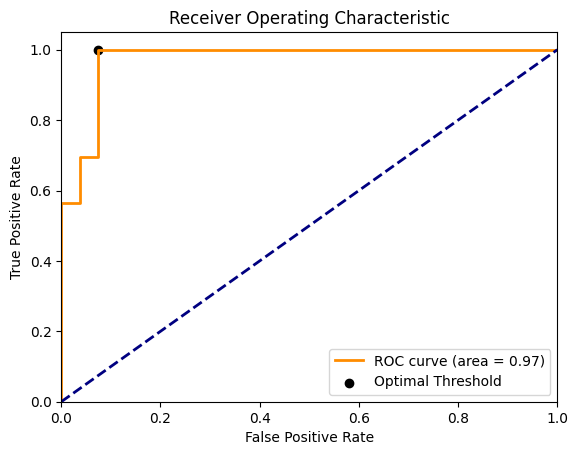

In [98]:
# Finding Threshold after Processing the data
df_open = build_dataset(output_directory_open_eye)
df_close = build_dataset(output_directory_closed_eye)

data_closed = df_close
data_opened = df_open

df_closed = pd.DataFrame(data_closed)
df_opened = pd.DataFrame(data_opened)

# Combine datasets and create labels: 0 for closed, 1 for opened
df_closed['label'] = 0
df_opened['label'] = 1

df_combined = pd.concat([df_closed, df_opened], ignore_index=True)

# Using average EAR values might be a simple approach to combine both eyes
df_combined['average_ear'] = df_combined[['ear_left', 'ear_right']].mean(axis=1)

# Generate labels and scores
labels = df_combined['label'].values
scores = df_combined['average_ear'].values

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('Optimal Threshold:', optimal_threshold)
print('AUC:', roc_auc)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [99]:
EAR_THRESHOLD = optimal_threshold
df_closed_eye_data = build_dataset(output_directory_closed_eye)
df_closed_eye_data

,image_path,ear_left,ear_right,overall_eye_status
0,data/preprocessed_closed_eye/8.jpg,0.164222,0.135731,Closed
1,data/preprocessed_closed_eye/9.jpg,0.115734,0.118242,Closed
2,data/preprocessed_closed_eye/14.jpg,0.206933,0.235782,Closed
3,data/preprocessed_closed_eye/28.jpg,0.110095,0.127998,Closed
4,data/preprocessed_closed_eye/29.jpg,0.167828,0.147809,Closed
5,data/preprocessed_closed_eye/15.jpg,0.249986,0.279837,Closed
6,data/preprocessed_closed_eye/16.jpg,0.211672,0.246845,Closed
7,data/preprocessed_closed_eye/12.jpg,0.263426,0.271900,Closed
8,data/preprocessed_closed_eye/11.jpg,0.211057,0.202563,Closed
9,data/preprocessed_closed_eye/10.jpg,0.139354,0.151443,Closed


In [100]:
EAR_THRESHOLD = optimal_threshold
df_open_eye_data = build_dataset(output_directory_open_eye)
df_open_eye_data

,image_path,ear_left,ear_right,overall_eye_status
0,data/preprocessed_open_eye/8.jpg,0.334767,0.307148,Open
1,data/preprocessed_open_eye/9.jpg,0.353199,0.328675,Open
2,data/preprocessed_open_eye/14.jpg,0.443645,0.589815,Open
3,data/preprocessed_open_eye/28.jpg,0.366140,0.450533,Open
4,data/preprocessed_open_eye/15.jpg,0.318271,0.386435,Open
5,data/preprocessed_open_eye/17.jpg,0.337414,0.383317,Open
6,data/preprocessed_open_eye/16.jpg,0.377659,0.484945,Open
7,data/preprocessed_open_eye/12.jpg,0.436623,0.575879,Open
8,data/preprocessed_open_eye/13.jpg,0.303525,0.400060,Open
9,data/preprocessed_open_eye/10.jpg,0.400960,0.406294,Open


In [101]:
df_combined = pd.concat([df_open_eye_data, df_closed_eye_data], ignore_index=True)
df_combined

,image_path,ear_left,ear_right,overall_eye_status
0,data/preprocessed_open_eye/8.jpg,0.334767,0.307148,Open
1,data/preprocessed_open_eye/9.jpg,0.353199,0.328675,Open
2,data/preprocessed_open_eye/14.jpg,0.443645,0.589815,Open
3,data/preprocessed_open_eye/28.jpg,0.366140,0.450533,Open
4,data/preprocessed_open_eye/15.jpg,0.318271,0.386435,Open
5,data/preprocessed_open_eye/17.jpg,0.337414,0.383317,Open
6,data/preprocessed_open_eye/16.jpg,0.377659,0.484945,Open
7,data/preprocessed_open_eye/12.jpg,0.436623,0.575879,Open
8,data/preprocessed_open_eye/13.jpg,0.303525,0.400060,Open
9,data/preprocessed_open_eye/10.jpg,0.400960,0.406294,Open


# Prepare the Data to Feed the Model

Before training a machine learning model, especially in the context of image processing, it is essential to properly prepare and format the data. This step ensures that the model can efficiently learn from the data during the training process. 

In [102]:
def prepare_dataframe(dataframe):
    # Initialize lists to hold processed images, labels, and EAR values
    image_data = []
    labels = []
    ears = []
    
    # Loop through each row in the DataFrame
    for index, row in dataframe.iterrows():
        # Load the image from the path
        img = Image.open(row['image_path']).convert('RGB')
        
        # Resize the image to a uniform size (e.g., 64x64 pixels)
        img = img.resize((64, 64))
        
        # Convert the image to a NumPy array and scale the pixel values to [0, 1]
        img_array = np.array(img) / 255.0
        
        # Append the processed image data to the list
        image_data.append(img_array)
        
        # Convert labels to binary (1 for 'Open', 0 for 'Closed')
        label = 1 if row['overall_eye_status'] == 'Open' else 0
        labels.append(label)
        
        # Calculate average EAR from both eyes
        ear_avg = (row['ear_left'] + row['ear_right']) / 2
        ears.append(ear_avg)
    
    # Create new DataFrame with processed image arrays, labels, and EAR values
    new_df = pd.DataFrame({
        'image_array': image_data,
        'label': labels,
        'ear': ears  # Add this column for EAR
    })
    
    return new_df

df_prepared = prepare_dataframe(df_combined)
df_prepared

,image_array,label,ear
0,"[[[0.5450980392156862, 0.5450980392156862, 0.5...",1,0.320957
1,"[[[0.5764705882352941, 0.5764705882352941, 0.5...",1,0.340937
2,"[[[0.984313725490196, 0.984313725490196, 0.984...",1,0.516730
3,"[[[0.32941176470588235, 0.32941176470588235, 0...",1,0.408337
4,"[[[0.984313725490196, 0.984313725490196, 0.984...",1,0.352353
5,"[[[0.23921568627450981, 0.23921568627450981, 0...",1,0.360365
6,"[[[0.24313725490196078, 0.24313725490196078, 0...",1,0.431302
7,"[[[0.9764705882352941, 0.9764705882352941, 0.9...",1,0.506251
8,"[[[0.984313725490196, 0.984313725490196, 0.984...",1,0.351792
9,"[[[0.03529411764705882, 0.03529411764705882, 0...",1,0.403627


# Model Implementation
Describes the setup and training of different models to classify eye states:
- **SVM (Support Vector Machine)**: A machine learning model used to classify images based on extracted features and EAR values.
- **CNN (Convolutional Neural Network)**: A more complex deep learning model that integrates images and EAR values to enhance prediction accuracy.


## Implementing SVM

In [103]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import make_pipeline

# Flatten the image data and add the 'ear' feature
X_images = np.array(df_prepared['image_array'].tolist()).reshape(len(df_prepared), -1)
X_ear = df_prepared['ear'].values.reshape(-1, 1)
X = np.hstack((X_images, X_ear))  # Combine image features with the 'ear' feature
y = df_prepared['label'].values

# Prepare the cross-validation procedure
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Create a pipeline that includes scaling and the SVM
model = make_pipeline(StandardScaler(), svm.SVC(kernel='linear'))

# Evaluate the model using cross-validation
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# Convert scores to percentages
scores_percentage = scores * 100

# Report the cross-validation scores as percentages
print("Mean cross-validation score as percentage: {:.2f}%".format(np.mean(scores_percentage)))

Mean cross-validation score as percentage: 88.00%


## Implementing CNN

In [104]:
import numpy as np
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

images = np.array([np.array(img, dtype=np.float32) for img in df_prepared['image_array']])
labels = np.array(df_prepared['label'].tolist(), dtype=np.int32)
ears = np.array(df_prepared['ear'].tolist(), dtype=np.float32)  # Assuming 'ear' column is also prepared

# K-Fold Cross Validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
best_accuracy = 0
best_model = None

# Initialize lists to store results from each fold
acc_per_fold = []
loss_per_fold = []

for train, test in kfold.split(images, labels):
    # Input layers
    img_input = Input(shape=(64, 64, 3))
    ear_input = Input(shape=(1,))
    
    # Image processing layers
    x = Conv2D(32, (3, 3), activation='relu')(img_input)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    
    # Concatenate EAR with the flattened output
    x = concatenate([x, ear_input])
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Model setup
    model = Model(inputs=[img_input, ear_input], outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    print(f'Training for fold {fold_no}...')
    model.fit([images[train], ears[train]], labels[train], batch_size=32, epochs=20, verbose=1)
    
    scores = model.evaluate([images[test], ears[test]], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: Loss = {scores[0]}; Accuracy = {scores[1]*100}%')
    
    # Append the scores for the fold to the results lists
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Track the best model
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = model
    
    fold_no += 1

if best_model:
    best_model.save('model/cnn_model.h5')
    print("Saved the best model with accuracy: {:.2f}%".format(best_accuracy * 100))

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold):.2f} (+- {np.std(acc_per_fold):.2f})')
print(f'> Loss: {np.mean(loss_per_fold):.2f}')
print('------------------------------------------------------------------------')


Training for fold 1...
Epoch 1/20
2/2 [==============================] - 0s 18ms/step - loss: 0.6942 - accuracy: 0.5000
Epoch 2/20
2/2 [==============================] - 0s 15ms/step - loss: 0.6493 - accuracy: 0.6500
Epoch 3/20
2/2 [==============================] - 0s 15ms/step - loss: 0.6806 - accuracy: 0.6750
Epoch 4/20
2/2 [==============================] - 0s 15ms/step - loss: 0.5704 - accuracy: 0.7750
Epoch 5/20
2/2 [==============================] - 0s 15ms/step - loss: 0.4927 - accuracy: 0.8250
Epoch 6/20
2/2 [==============================] - 0s 17ms/step - loss: 0.4355 - accuracy: 0.8500
Epoch 7/20
2/2 [==============================] - 0s 16ms/step - loss: 0.4425 - accuracy: 0.8250
Epoch 8/20
2/2 [==============================] - 0s 16ms/step - loss: 0.3016 - accuracy: 0.8500
Epoch 9/20
2/2 [==============================] - 0s 16ms/step - loss: 0.2084 - accuracy: 0.9500
Epoch 10/20
2/2 [==============================] - 0s 16ms/step - loss: 0.2077 - accuracy: 0.9500
Epoch 

### Testing the saved CNN model 

In [105]:

def load_and_preprocess_image(image_path):
    # Load the image and handle preprocessing
    image = preprocessed_eye_advanced(image_path)  

    # Convert to RGB if single-channel
    if len(image.shape) == 2 or image.shape[2] == 1:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    resized_image = cv2.resize(image_rgb, (64, 64))
    processed_image = resized_image.astype('float32') / 255.0
    processed_image = np.expand_dims(processed_image, axis=0)

    # Detect faces, assuming the original image is required for this
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    faces = detector(gray, 1)

    # Calculate EAR, assuming one face per image for simplicity
    ear = 0
    if len(faces) > 0:
        shape = predictor(gray, faces[0])
        eye_points = np.array([(shape.part(i).x, shape.part(i).y) for i in range(36, 42)])  # Right eye
        ear = eye_aspect_ratio(eye_points)

    return processed_image, image_rgb, ear

def predict_eye_state(image_path, model_path='model/best_model.h5'):
    """Load model, process the image, calculate EAR, and make a prediction."""
    model = load_model(model_path)
    processed_image, original_image, ear = load_and_preprocess_image(image_path)

    # Prediction using the model, this is where EAR and image are used as inputs
    prediction = model.predict([processed_image, np.array([[ear]])])

    # Updated the threshold here to 0.3
    predicted_class = int(prediction > 0.1) 
    print(predicted_class)
    state = "Open" if predicted_class == 1 else "Closed"

    print(f"The eye is {state}.")
    plt.figure(figsize=(5, 5))
    plt.imshow(original_image)
    plt.title(f'Prediction: The eye is {state}')
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 45ms/step
1
The eye is Open.


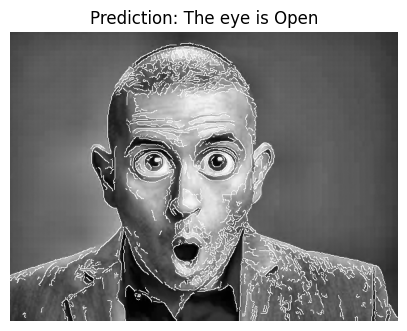

In [106]:
# Path to the image to be tested
image_path = 'generalization/gen_test_1.png' 

# Call the function to predict eye state and display the image
predict_eye_state(image_path)

1/1 [==============================] - 0s 41ms/step
1
The eye is Open.


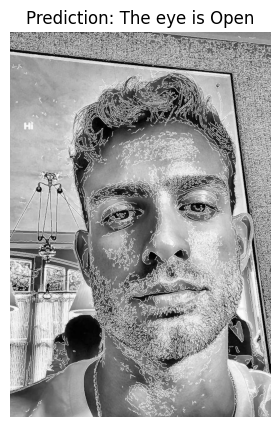

In [107]:
# Path to the image to be tested
image_path = 'generalization/gen_test_2.jpg' 

# Call the function to predict eye state and display the image
predict_eye_state(image_path)

1/1 [==============================] - 0s 41ms/step
0
The eye is Closed.


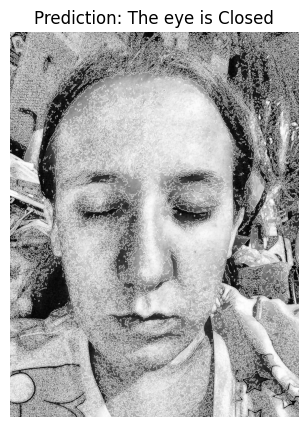

In [108]:
# Path to the image to be tested
image_path = 'generalization/gen_test_3.jpg' 

# Call the function to predict eye state and display the image
predict_eye_state(image_path)

1/1 [==============================] - 0s 40ms/step
0
The eye is Closed.


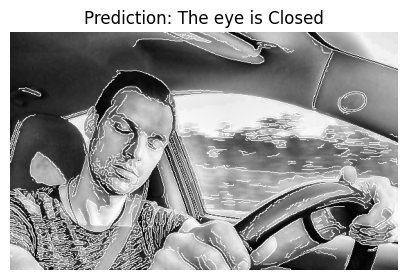

In [109]:
# Path to the image to be tested
image_path = 'generalization/gen_test_4.png' 

# Call the function to predict eye state and display the image
predict_eye_state(image_path)